[Churn dataset](https://github.com/rbstern/causality_book/blob/master/code/dados/churn.csv).

In [1]:
import pandas as pd
import numpy as np # from daft import PGM
df = pd.read_csv("churn.csv")

Variáveis:
```python
['escore_credito', 'pais', 'genero', 'idade', 'tempo_consumidor',
 'dinheiro_em_conta', 'compras_realizadas', 'tem_cartao_de_credito',
 'conta_ativa', 'salario', 'deixou_o_banco']
```

Para simplificar o exercício, não vamos incluir váriaveis não observadas apesar de algumas poderem ser relevantes como o número de bancos ativos do cliente.

___

In [2]:
from pgmpy.models import BayesianNetwork
model = BayesianNetwork()
model.add_nodes_from(list(df.columns))
model.add_edges_from([
    ('idade', 'tempo_consumidor'),
    ('idade', 'salario'), ('pais', 'salario'), ('genero', 'salario'),
    ('idade', 'escore_credito'), ('pais', 'escore_credito'), ('tempo_consumidor', 'escore_credito'), ('salario', 'escore_credito'), ('dinheiro_em_conta', 'escore_credito'),
    ('salario', 'dinheiro_em_conta'),
    ('salario', 'tem_cartao_de_credito'), ('escore_credito', 'tem_cartao_de_credito'),
    ('dinheiro_em_conta', 'compras_realizadas'), ('tem_cartao_de_credito', 'compras_realizadas'),
    ('dinheiro_em_conta', 'conta_ativa'), ('compras_realizadas', 'conta_ativa'),
    ('idade', 'deixou_o_banco'), ('conta_ativa', 'deixou_o_banco'), ('dinheiro_em_conta', 'deixou_o_banco'),
])

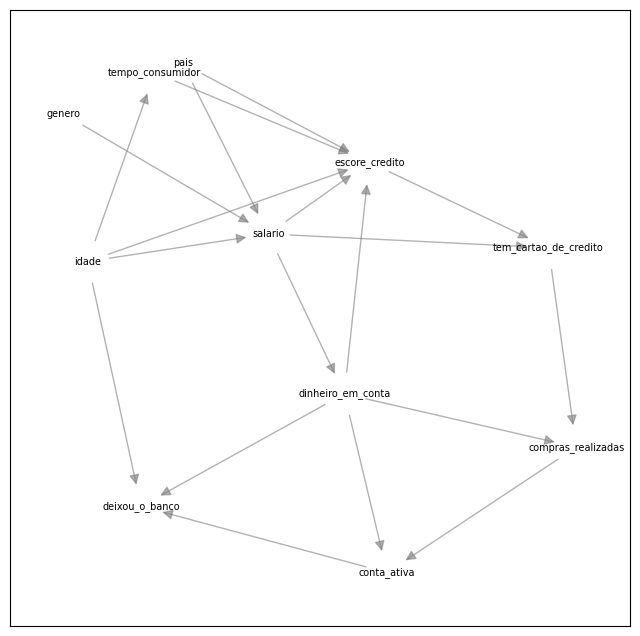

In [3]:
import networkx as nx
import pylab as plt
nx_graph = nx.DiGraph(model.edges())

plt.figure(figsize=(8, 8))

position_dicts = nx.kamada_kawai_layout(nx_graph)
# position_dicts.update({"pais": np.array([position_dicts["genero"][0], position_dicts["pais"][1]])})
# position_dicts.update({"genero": np.array([position_dicts["dinheiro_em_conta"][0], position_dicts["salario"][1]])})
# position_dicts.update({"deixou_o_banco": np.array([position_dicts["deixou_o_banco"][0], position_dicts["tem_cartao_de_credito"][1]])})

nx.draw_networkx_edges(nx_graph, position_dicts, edge_color='gray', node_size=1000, alpha=0.6, arrowstyle="-|>", arrowsize=15)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color='black')
plt.show()

Justificando a escolha do grafo causal:

- idade, pais, genero não são definida pelas outras variáveis.
- Fazer uma intervenção no valor da idade altera o tempo_consumidor. Fazer intervenção nas outras variáveis não muda essa variável (estou considerando que a variável deixou_o_banco está num timestamp posterior às outras).
- Alterar o pais, idade ou genero podem alterar o salário (todos esses aspectos podem alterar o emprego atual da pessoa e consequentemente o salario). Mexer nas outras variáveis não deveria alterar o salario.
- O escore_credito costuma ser um modelo definido por algumas variáveis cadastrais como idade, pais, salario, e informações internas de saúde financeira e de conhecimento do comportamento como dinheiro_em_conta e tempo consumidor.
- A quantidade de dinheiro em conta está definida pelo salário.
- A obtenção de um cartão de crédito está definido pelo escore de crédito e pelo salário.
- A pessoa só faz compras se tiver ou dinheiro em conta ou se tiver o cartão de crédito.
- A conta está ativa se ele realiza compras nela ou se tem dinheiro nela.
- O cliente deixa o banco por questões de idade (falecimento por exemplo) ou se a conta não está mais ativa ou sem dinheiro nela.

In [4]:
from pgmpy.inference import CausalInference
inference = CausalInference(model=model)

all_backdoor_adjustment_sets = list(inference.get_all_backdoor_adjustment_sets("tem_cartao_de_credito", "deixou_o_banco"))
all_backdoor_adjustment_sets

[frozenset({'dinheiro_em_conta', 'idade'}),
 frozenset({'escore_credito', 'salario'})]

In [5]:
proposed_backdoor_set = list(set(df.columns.to_list()) - set(["tem_cartao_de_credito", "compras_realizadas", "conta_ativa", "deixou_o_banco"]))
assert inference.is_valid_backdoor_adjustment_set("tem_cartao_de_credito", "deixou_o_banco", proposed_backdoor_set)
proposed_backdoor_set

['salario',
 'tempo_consumidor',
 'escore_credito',
 'genero',
 'pais',
 'idade',
 'dinheiro_em_conta']

In [6]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [7]:
def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list + ["tem_cartao_de_credito"]), df.deixou_o_banco

XZ, y = return_XZ_y(df, proposed_backdoor_set)

In [8]:
cat_cols = XZ.select_dtypes(include="object").columns.to_list()
model = make_pipeline(
    ColumnTransformer(
        [('target', TargetEncoder(cols=cat_cols, smoothing=100, min_samples_leaf=10), cat_cols)
        ], remainder='passthrough'
    ),
    GridSearchCV(
        estimator=HistGradientBoostingClassifier(random_state=42),
        cv=KFold(shuffle=True, random_state=42),
        param_grid={"max_depth": [2, 5, 10, None]},
        scoring="roc_auc"
    )).fit(XZ, y)

In [9]:
pd.DataFrame(model.named_steps["gridsearchcv"].cv_results_).filter(["param_max_depth", "mean_test_score"])

,param_max_depth,mean_test_score
0,2,0.783241
1,5,0.777521
2,10,0.773903
3,None,0.771486


In [10]:
from sklearn.inspection import permutation_importance

pd.DataFrame(
    list(zip(XZ.columns, permutation_importance(model, XZ, y, scoring="roc_auc")["importances_mean"])),
    columns=["feat", "importance"]
)

,feat,importance
0,salario,0.002073
1,tempo_consumidor,0.000293
2,escore_credito,0.005493
3,genero,0.016325
4,pais,0.024057
5,idade,0.207608
6,dinheiro_em_conta,0.016355
7,tem_cartao_de_credito,0.000000


In [13]:
model.predict(XZ.assign(tem_cartao_de_credito=1)).mean() - model.predict(XZ.assign(tem_cartao_de_credito=0)).mean()

0.0

Não temos efeito causal de ter cartão de crédito em sair do banco. Nesse caso, se o banco pretende dar cartões para reter mais clientes, ele não obterá sucesso.

___